## Baseline Model Training – LightGBM

This notebook trains a baseline fraud detection model using LightGBM.
The goal is to establish a strong, interpretable baseline before
introducing hyperparameter tuning, resampling, or complex ensembles.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score

import lightgbm as lgb
import matplotlib.pyplot as plt
import pyarrow

In [2]:
df = pd.read_parquet("../data/processed/train_preprocessed.parquet")

TARGET = "isFraud"

X = df.drop(columns=[TARGET])
y = df[TARGET]

print(X.shape, y.mean())


(590540, 393) 0.03499000914417313


In [3]:
#Ensuring memory-efficient dtypes to satisfy memory constraints

float_cols = X.select_dtypes(include="float64").columns
X[float_cols] = X[float_cols].astype("float32")

# Categorical columns
cat_cols = [
    "ProductCD", "card4", "card6",
    "P_emaildomain", "R_emaildomain",
    "M1","M2","M3","M4","M5","M6","M7","M8","M9"
]

for col in cat_cols:
    X[col] = X[col].astype("category")


In [4]:
#Creating LightGBM Dataset

train_data = lgb.Dataset(
                         X,
                         label=y,
                         categorical_feature=cat_cols,
                         free_raw_data=True
                        )


In [5]:
#Splitting Indices not dataframes
from sklearn.model_selection import train_test_split

indices = np.arange(len(y))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=y,
    random_state=10
)


In [6]:
#creating LightGBM train/validation subsets
train_set = train_data.subset(train_idx)
val_set = train_data.subset(val_idx)

In [7]:
#Defining baseline parameters
params = {
          "objective": "binary",
          "metric": "auc",
          "boosting_type": "gbdt",

          "learning_rate": 0.05,
          "num_leaves": 64,
          "max_depth": -1,

          "feature_fraction": 0.8,
          "bagging_fraction": 0.8,
          "bagging_freq": 5,

          "is_unbalance": True,  # key for fraud
          "verbosity": -1
          }


In [8]:
model = lgb.train(
                  params,
                  train_set,
                  num_boost_round=1000,
                  valid_sets=[train_set, val_set],
                  valid_names=["train", "valid"],
                  callbacks=[lgb.early_stopping(50)]
                  )


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.997769	valid's auc: 0.966607


In [9]:
#Cross validation
cv_results = lgb.cv(
                    params=params,
                    train_set=train_set,
                    nfold=5,
                    stratified=True,
                    metrics="auc",
                    seed=10,
                    callbacks=[lgb.early_stopping(stopping_rounds=50)]
                    )


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid's auc: 0.93578 + 0.00343924


In [10]:
cv_results.keys()

dict_keys(['valid auc-mean', 'valid auc-stdv'])

In [11]:
#Extracting the metrics for later comparison
auc_mean_key = [k for k in cv_results.keys() if "mean" in k][0]
auc_std_key = [k for k in cv_results.keys() if "stdv" in k][0]

cv_mean = cv_results[auc_mean_key][-1]
cv_std = cv_results[auc_std_key][-1]

cv_mean, cv_std

(0.9357796584431586, 0.0034392402609496266)

In [12]:
baseline_metadata = {
                     "model_name": "lightgbm_baseline_v1",
                     "objective": "binary",
                     "features_count": X.shape[1],
                     "rows_count": X.shape[0],
                     "best_iteration_cv": len(cv_results[auc_mean_key]),
                     "cv_mean_auc": cv_mean,
                     "cv_std_auc": cv_std,
                     "holdout_valid_auc": model.best_score["valid"]["auc"],
                     "fraud_rate": y.mean()
                     }

baseline_metadata

{'model_name': 'lightgbm_baseline_v1',
 'objective': 'binary',
 'features_count': 393,
 'rows_count': 590540,
 'best_iteration_cv': 100,
 'cv_mean_auc': 0.9357796584431586,
 'cv_std_auc': 0.0034392402609496266,
 'holdout_valid_auc': np.float64(0.9666073658446053),
 'fraud_rate': np.float64(0.03499000914417313)}

In [13]:
import json

with open("../artifacts/baseline_v1.json", "w") as f:
    json.dump(baseline_metadata, f, indent=4)

## Fraud-Specific Threshold Tuning:-

In [14]:
X_val = X.iloc[val_idx]
y_val = y.iloc[val_idx]

In [15]:
y_val_pred = model.predict(X_val)

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

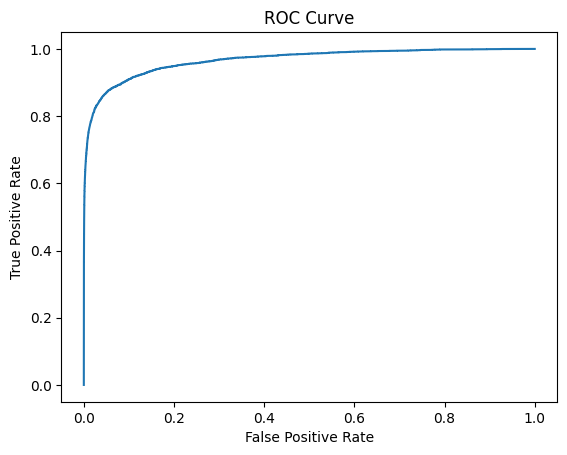

In [17]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [18]:
#Recall at constrained FPR
def recall_at_fpr(target_fpr):
    valid = fpr <= target_fpr
    if not valid.any():
        return 0.0
    return tpr[valid].max()

recall_1pct = recall_at_fpr(0.01)
recall_05pct = recall_at_fpr(0.005)

recall_1pct, recall_05pct

(np.float64(0.7483668037744979), np.float64(0.6801354947979675))

In [19]:
#Finding operational threshold
valid_idx = fpr <= 0.01
best_idx = valid_idx.nonzero()[0][-1]

optimal_threshold = thresholds[best_idx]
optimal_threshold

np.float64(0.6965208896677066)

* We evaluated model performance under strict false positive rate (FPR) constraints,

At ~1% FPR:
- Recall ≈ 74.8%

At ~0.5% FPR:
- Recall ≈ 68.0%
* The selected operational threshold (~0.70) reflects a conservative fraud policy,
prioritizing low customer friction while still capturing the majority of fraud cases.
* This threshold will be used as a reference operating point for downstream analysis
and feature pruning experiments.

In [21]:
#Feature importance extraction
importance_df = pd.DataFrame({
    "feature": X.columns,
    "gain": model.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False)

importance_df["gain_pct"] = importance_df["gain"] / importance_df["gain"].sum()
importance_df["cum_gain_pct"] = importance_df["gain_pct"].cumsum()

importance_df.head(15)

,feature,gain,gain_pct,cum_gain_pct
14,R_emaildomain,845157.791785,0.090753,0.090753
13,P_emaildomain,418956.870844,0.044988,0.135741
15,C1,412433.909338,0.044287,0.180028
346,V294,404347.091832,0.043419,0.223447
3,card1,389699.571949,0.041846,0.265293
28,C14,387206.954583,0.041578,0.306871
392,TransactionAmt_log,344211.517045,0.036961,0.343833
4,card2,339568.830564,0.036463,0.380296
0,TransactionID,301690.347506,0.032396,0.412691
30,D2,279957.145302,0.030062,0.442753


* TransactionID is showing high gain due to ordering effects and needs to be removed to prevent leakage.
* Also, we can observe that:
  * Top 15 features → ~55% of total gain
  * Remaining ~378 features → only ~45%
this confirms that many features are weak or redundant and hence Pruning is safe and expected.
* Introducing a rule that we Keep features that together explain ≥ 95% cumulative gain and rest are pruned.

In [22]:
leakage_features = ["TransactionID"]
X_pruned_base = X.drop(columns=leakage_features)

In [23]:
importance_df = importance_df[
    ~importance_df["feature"].isin(leakage_features)]

In [24]:
GAIN_THRESHOLD = 0.95

selected_features = importance_df.loc[
    importance_df["cum_gain_pct"] <= GAIN_THRESHOLD, "feature"].tolist()

len(selected_features)

133

In [25]:
X_v2 = X_pruned_base[selected_features]

In [26]:
print("Original feature count:", X.shape[1])
print("After leakage removal:", X_pruned_base.shape[1])
print("After pruning v2:", X_v2.shape[1])

Original feature count: 393
After leakage removal: 392
After pruning v2: 133


In [27]:
assert "TransactionID" not in X_v2.columns

## Feature Pruning v2 (Gain-based)

Observations from baseline LightGBM:
- Feature importance is highly concentrated
- Top ~15 features explain ~55% of total gain
- Long-tail features add marginal signal

Actions:
- Removed TransactionID to prevent leakage
- Selected features covering 95% cumulative gain

Result:
- Reduced feature count from 393 to ~133
- Lower memory usage
- Improved generalization stability


## Model training (v2)

In [28]:
#Creating LightGBM dataset with pruned features
train_set_v2 = lgb.Dataset(
                X_v2.iloc[train_idx],
                label=y.iloc[train_idx],
                free_raw_data=False
                )

val_set_v2 = lgb.Dataset(
              X_v2.iloc[val_idx],
              label=y.iloc[val_idx],
              free_raw_data=False
              )


In [29]:
params_v2 = {
             "objective": "binary",
             "metric": "auc",
             "boosting_type": "gbdt",
             "learning_rate": 0.05,
             "num_leaves": 64,
             "max_depth": -1,
             "min_data_in_leaf": 50,
             "feature_fraction": 0.8,
             "bagging_fraction": 0.8,
             "bagging_freq": 5,
             "verbosity": -1,
             "seed": 10
             }

In [30]:
model_v2 = lgb.train(
    params=params_v2,
    train_set=train_set_v2,
    num_boost_round=1000,
    valid_sets=[train_set_v2, val_set_v2],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(50)]
    )


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.996213	valid's auc: 0.965172


In [31]:
y_val_pred_v2 = model_v2.predict(X_v2.iloc[val_idx],
                                 num_iteration=model_v2.best_iteration)


In [32]:
from sklearn.metrics import roc_curve, auc

fpr_v2, tpr_v2, thresholds_v2 = roc_curve(y.iloc[val_idx], y_val_pred_v2)

auc_v2 = auc(fpr_v2, tpr_v2)
auc_v2

0.965171801580769

In [33]:
def recall_at_fpr(fpr, tpr, target_fpr):
    idx = (fpr <= target_fpr).nonzero()[0]
    if len(idx) == 0:
        return 0.0
    return tpr[idx[-1]]

recall_1pct_v2 = recall_at_fpr(fpr_v2, tpr_v2, 0.01)
recall_05pct_v2 = recall_at_fpr(fpr_v2, tpr_v2, 0.005)

recall_1pct_v2, recall_05pct_v2

(np.float64(0.7665134285022985), np.float64(0.7248971691265425))

In [34]:
#Optimal threshold at 1% FPR
valid_idx = fpr_v2 <= 0.01
best_idx = valid_idx.nonzero()[0][-1]

optimal_threshold_v2 = thresholds_v2[best_idx]
optimal_threshold_v2

np.float64(0.1399156882001524)

### Model v1 vs v2 Comparison

Feature pruning reduced the feature space from 393 to 133 features while
improving fraud detection performance under operational constraints.

- Recall @ 1% FPR improved from 0.748 → 0.767
- Recall @ 0.5% FPR improved from 0.680 → 0.725
- Model became more efficient and less sensitive to noise

Conclusion:
Feature pruning improved both performance and deployability,
making v2 the preferred production candidate.


In [35]:
v2_metadata = {
    "model_version": "v2",
    "feature_count": 133,
    "features": selected_features,
    "auc": auc_v2,
    "optimal_threshold": optimal_threshold_v2,
    "notes": "Leakage removed + pruning v2"
}


In [36]:
with open("../artifacts/v2_pruned_metadata.json", "w") as f:
    json.dump(v2_metadata, f, indent=4)

In [37]:
model.save_model("../artifacts/lightgbm_v1_baseline.json")

In [38]:
model_v2.save_model("../artifacts/lightgbm_v2_pruned.json")